### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import utils as u
from model_utils import Model

### Pandas Options

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

#### Jupyter Options

In [3]:
%load_ext autoreload
%autoreload 2

%load_ext lab_black

ERROR:root:Cannot parse: 4:0: %load_ext lab_black
Traceback (most recent call last):
  File "c:\users\david\appdata\local\programs\python\python37\lib\site-packages\lab_black.py", line 67, in format
    cell = _format_code(cell)
  File "c:\users\david\appdata\local\programs\python\python37\lib\site-packages\lab_black.py", line 20, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "c:\users\david\appdata\local\programs\python\python37\lib\site-packages\black.py", line 669, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "c:\users\david\appdata\local\programs\python\python37\lib\site-packages\black.py", line 758, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 4:0: %load_ext lab_black


### Ingesting the dataset


In [4]:
SPREADSHEET_PATH = "raw/fuzzy_match_app_check.xlsx"

df = pd.read_excel(SPREADSHEET_PATH, sheet_name=0)

### Preparing list for NLP

In [5]:
# These are words to
words_to_ignore = [
    "capital",
    "management",
    "partners",
    "group",
    "&",
    "asset",
    "investment",
    "of",
    "fund",
    "services",
    "insurance",
    "global",
    "financial",
    "the",
    "investments",
    "consulting",
    "bank",
    "international",
    "solutions",
    "wealth",
    "pension",
    "associates",
    "media",
    "new",
    "london",
    "risk",
    "securities",
    "real",
    "gaming",
    "estate",
    "trust",
    "co",
    "office",
    "family",
    "company",
    "de",
    "research",
    "funds",
    "foundation",
]

# These common words will be used in searching for acronyms
common_words = []
with open("1-1000.txt") as f:
    for line in f:
        common_words.append(line.rstrip())

### Create a new dataset with the features to learn from

In [6]:
base_df = pd.DataFrame()

base_df["name_a"] = df["name_clean_co_pam"]
base_df["name_b"] = df["match_option"]

# Get the acronyms for a and b
base_df["acr_a"] = base_df["name_a"].apply(
    lambda x: u.get_acronym(x, words_to_ignore, common_words)
)
base_df["acr_b"] = base_df["name_b"].apply(
    lambda x: u.get_acronym(x, words_to_ignore, common_words)
)

# Create a numerical field for the same acronyms
base_df["acr_match"] = base_df.apply(
    lambda row: u.acronym_checker(row["acr_a"], row["acr_b"]), axis=1
)

# Get the number of words
base_df["num_words_a"] = base_df["name_a"].apply(lambda x: u.get_number_words(x))
base_df["num_words_b"] = base_df["name_b"].apply(lambda x: u.get_number_words(x))

# Get the length of the strings
base_df["len_a"] = base_df["name_a"].apply(lambda x: len(str(x)))
base_df["len_b"] = base_df["name_b"].apply(lambda x: len(str(x)))

# Get Jaro Winkler distance
base_df["JW_distance"] = base_df.apply(
    lambda row: u.jaro_winkler_distance(row["name_a"], row["name_b"]), axis=1
)

# Get Levenshtein distance
base_df["LV_distance"] = base_df.apply(
    lambda row: u.levenshtein_distance(row["name_a"], row["name_b"]), axis=1
)

# Get the target
base_df["target"] = df["accept_match"].apply(lambda x: u.convert_target(x))

In [13]:
base_df

,name_a,name_b,acr_a,acr_b,acr_match,num_words_a,num_words_b,len_a,len_b,JW_distance,LV_distance,target
0,HM FUND MANAGEMENT,HP FUND MANAGEMENT,hm,hp,0,3,3,18,18,0.860784,1,0
1,JLH CAPITAL INVESTMENT,JCR CAPITAL INVESTMENT,jlh,jcr,0,3,3,22,22,0.900455,2,0
2,TENOR CAPITAL MANAGEMENT,THEORIA CAPITAL MANAGEMENT,None,None,0,3,3,24,26,0.874624,4,0
3,ARCIS CAPITAL PARTNERS,ABRIS CAPITAL PARTNERS,None,None,0,3,3,22,22,0.944156,2,0
4,BLS CAPITAL,BLG CAPITAL,bls,blg,0,2,2,11,11,0.951515,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3374,ARIA INVESTMENT PARTNERS,ARMORICA INVESTMENT PARTNERS,aria,None,0,3,3,24,28,0.906349,4,0
3375,BLUE CROSS BLUE SHIELD OF MICHIGAN,BLUE CROSS & BLUE SHIELD OF MICHIGAN,None,None,0,6,7,34,36,0.947712,2,1
3376,IPAC ASSET MANAGEMENT,ICM ASSET MANAGEMENT,ipac,icm,0,3,3,21,20,0.924850,3,0
3377,ADI CAPITAL MANAGEMENT,AIS CAPITAL MANAGEMENT,adi,ais,0,3,3,22,22,0.972727,2,0


### Split the dataset into train, dev, test set

In [7]:
base_df = base_df.sample(frac=1).reset_index(drop=True)

# Separate majority and minority classes
majority_df = base_df[base_df.target == base_df["target"].value_counts().index[0]]
minority_df = base_df[base_df.target == base_df["target"].value_counts().index[-1]]

# Downsample majority class
majority_downsampled_df = resample(
    majority_df,
    replace=False,  # sample without replacement
    n_samples=len(minority_df),  # to match minority class
    random_state=123,
)  # reproducible results


# Combine minority class with downsampled majority class
downsampled_df = pd.concat([majority_downsampled_df, minority_df])

# Display new class counts
downsampled_df.target.value_counts()


non_numerical_cols = ["name_a", "name_b", "acr_a", "acr_b"]
feature_columns = [
    "acr_match",
    "JW_distance",
    "LV_distance",
    "num_words_a",
    "num_words_b",
    "len_a",
    "len_b",
]
target_column = "target"

X = downsampled_df.drop("target", axis=1)
y = downsampled_df.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = X_train[feature_columns]
X_test = X_test[feature_columns]

In [14]:
downsampled_df

,name_a,name_b,acr_a,acr_b,acr_match,num_words_a,num_words_b,len_a,len_b,JW_distance,LV_distance,target
2161,ARA PARTNERS,AA PARTNERS,ara,aa,0,2,2,12,11,0.865909,1,0
2542,HB CAPITAL MANAGEMENT,HT CAPITAL MANAGEMENT,hb,ht,0,3,3,21,21,0.926429,1,0
1827,ACCENT CAPITAL MANAGEMENT,ACT CAPITAL MANAGEMENT,None,None,0,3,3,25,22,0.858909,3,0
3084,AON ASSET MANAGEMENT,AO ASSET MANAGEMENT,aon,ao,0,3,3,20,19,0.888421,1,0
212,MMIP INVESTMENT MANAGEMENT,MU INVESTMENT MANAGEMENT,mmip,mu,0,3,3,26,24,0.835493,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3363,SANLAM INVESTMENT MANAGEMENT,SANLAM INVESTMENTS MANAGEMENT,None,None,0,3,3,28,29,0.993103,1,1
3367,ARION INVESTMENT MANAGEMENT,ARION INVESTMENT MANGEMENT,None,None,0,3,3,27,26,0.992593,1,1
3370,RAYNE CAPITAL MANAGEMENT,RAYENS CAPITAL MANAGEMENT,None,None,0,3,3,24,25,0.980944,2,1
3372,ALQUITY INVESTMENT MANAGEMENT,ALQUITY INVESTMENT MANAGMENT,None,None,0,3,3,29,28,0.985961,1,1


In [11]:
X_train

,acr_match,JW_distance,LV_distance,num_words_a,num_words_b,len_a,len_b
1519,0,0.888848,3,3,3,23,22
124,0,0.950246,1,3,4,28,29
1618,0,0.991667,1,3,3,23,24
1855,0,0.970635,1,3,3,28,27
866,0,0.915870,3,3,3,20,23
...,...,...,...,...,...,...,...
1937,0,0.966667,3,3,4,15,18
2086,0,0.973913,3,4,3,23,20
2951,0,0.970588,5,5,4,34,29
829,0,0.972414,4,4,3,29,25


### Train Random Forest model

Recall Baseline: 1.0 Test: 0.85 Train: 0.95
Precision Baseline: 0.48 Test: 0.9 Train: 0.99
Roc Baseline: 0.5 Test: 0.96 Train: 0.99


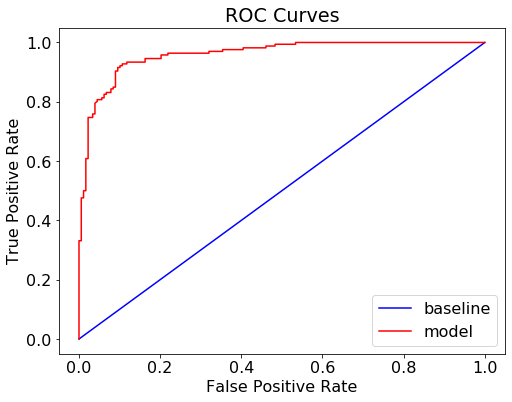

<Figure size 432x288 with 0 Axes>

In [8]:
my_model = Model(X_train, y_train, X_test, y_test)
classified = my_model.train_RF(return_classifier=True)

# print(my_model.grid_search())
# The best model has the following parameters:
# {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}

In [16]:
classified.predict(X_test)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,

In [17]:
%store X_test

Stored 'X_test' (DataFrame)


### Save Model

In [9]:
import joblib

filename = "trained_model/finalized_model.sav"
joblib.dump(classified, filename)

['trained_model/finalized_model.sav']

### Plot Confusion Matrix

Confusion matrix, without normalization
[[162  16]
 [ 25 141]]
Normalized confusion matrix
[[0.91 0.09]
 [0.15 0.85]]


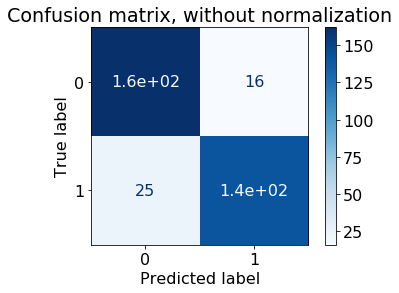

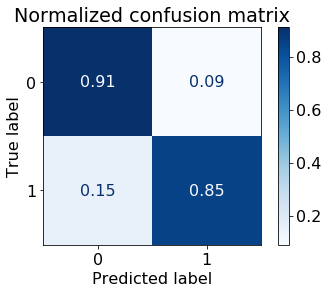

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(
        classified,
        X_test,
        y_test,
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()